In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

def rk4_step(x, magnet_pos, t, dt, rhs):
    k1 = rhs(x, magnet_pos, t)
    k2 = rhs(x + dt/2*k1, magnet_pos, t + 0.5*dt)
    k3 = rhs(x + dt/2*k2, magnet_pos, t + 0.5*dt)
    k4 = rhs(x + dt*k3,   magnet_pos, t + dt)
    return x + (k1 + 2*k2 + 2*k3 + k4)*dt/6

In [81]:
class magnet:
    def __init__(self, pos, mom):
        self.pos = np.array(pos)
        self.mom = np.array(mom)
    
    def potential(self, mu0, l, theta):
        pen_direction = np.array([np.sin(theta), np.cos(theta)])
        pen_mom = self.mom * pen_direction
        pos = l * pen_direction
        
        r = pos - self.pos
        r_norm = np.linalg.norm(r)
        
        if r_norm < 1e-9:
            return 0.0

        m1_dot_m2 = np.dot(pen_mom, self.mom)
        m1_dot_r  = np.dot(pen_mom, r)
        m2_dot_r  = np.dot(self.mom, r)
        
        return - (mu0 / (4 * np.pi)) * (
            m1_dot_m2 - 3.0 * (m1_dot_r * m2_dot_r) / (r_norm**2)
        ) / (r_norm**3)
    
    def diff(self, mu0, l, theta, dtheta=1e-6):
        val0 = self.potential(mu0, l, theta - dtheta)
        val1 = self.potential(mu0, l, theta + dtheta)
        return (val0 - val1) / (2 * dtheta)


In [82]:
class system:
    def __init__(self, ic, damp=0.2, moment=1, dt=0.1, t_max=100):
        self.angle = ic[0]
        self.vel = ic[1]
        self.damp = damp
        self.moment = moment
        self.dt = dt
        self.t_max = t_max
        self.num_steps = int(self.t_max / self.dt)
        self.magnets = []
        self.final_angles = []
        self.final_velocities = []
        self.equil_points = []
        
    def add_magnet(self, magnet):
        self.magnets.append(magnet)
    
    def rhs(self, x, magnets, t):
        m = 1
        g = 1
        l = 1
        mu0 = 1
        
        theta = x[0]
        dtheta = x[1]
        
        # Gravity + damping
        L = -g/l * np.sin(theta) - self.damp * dtheta / (m * l**2)
        
        if len(magnets) == 0:
            return np.array([dtheta, L])
        
        for magnet in magnets:
            L += magnet.diff(mu0, l, theta)
        
        return np.array([dtheta, L])
    
    def solve(self, save=False):
        x_list = [np.array([self.angle, self.vel])]
        
        for i in range(self.num_steps - 1):
            t = (i + 1) * self.dt
            x_next = rk4_step(x_list[-1], self.magnets, t, self.dt, self.rhs)
            x_list.append(x_next)
        
        x_array = np.array(x_list)
        
        self.final_angles = x_array[:, 0]
        self.final_velocities = x_array[:, 1]
        return x_array
    
    def plot_solution(self, ax=None, color=None):
        if ax is None:
            _, ax = plt.subplots()
        ax.set_title("Solution")
        ax.set_xlabel("Time")
        ax.set_ylabel("Angle")
        ax.plot(np.linspace(0, self.t_max, self.num_steps), self.final_angles, 
                color=color, alpha=0.6)
    
    def plot_phase(self, ax=None, color=None):
        if ax is None:
            _, ax = plt.subplots()
        ax.set_title("Phase Trajectory")
        ax.set_xlabel("Angle")
        ax.set_ylabel("Velocity")
        ax.plot(self.final_angles, self.final_velocities, color=color, alpha=0.6)
        
    def plot_vectorfield(self, 
            ax=None, 
            num_angles=20, 
            range_angles=[-np.pi, np.pi],
            num_velolcities=20,
            range_velocities=[-4, 4]
        ):
        if ax is None:
            _, ax = plt.subplots()
        ax.set_title("Vector Field")
        ax.set_xlabel("Angle")
        ax.set_ylabel("Velocity")
            
        angles = np.linspace(range_angles[0], range_angles[1], num_angles)
        velocities = np.linspace(range_velocities[0], range_velocities[1], num_velolcities)
        X, Y = np.meshgrid(angles, velocities)
        
        U = np.zeros(X.shape)
        V = np.zeros(Y.shape)
        for i, j in np.ndindex(U.shape):
            val = self.rhs([X[i, j], Y[i, j]], self.magnets, 0)
            U[i, j] = val[0]
            V[i, j] = val[1]
        
        ax.streamplot(X, Y, U, V)
        ax.quiver(X, Y, U, V)

    def are_angles_equivalent(self, equil1, equil2, tol=1e-6):
        normalized_angle1 = equil1[0] % (2 * np.pi)
        normalized_angle2 = equil2[0] % (2 * np.pi)
        return np.isclose(normalized_angle1, normalized_angle2, atol=tol)
    
    def find_equil_points(self, num_points=50):
        equil_points_temp = []
        angles_to_try = np.linspace(-np.pi, np.pi, num_points, endpoint=False)
        
        for angle in angles_to_try:
            equillibrium = fsolve(self.rhs, [angle, 0.0], args=(self.magnets, 0))
            if np.isclose(equillibrium[1], 0.0, atol=1e-5):
                if not any(self.are_angles_equivalent(equillibrium, ep, tol=1e-6) 
                           for ep in equil_points_temp):
                    equil_points_temp.append(equillibrium)
        
        self.equil_points = np.array(equil_points_temp)
        return self.equil_points

    def check_stability(self, eq):
        h = 1e-6
        dd_minus = self.rhs([eq[0] - h, 0.0], self.magnets, 0.0)[1]
        dd_plus  = self.rhs([eq[0] + h, 0.0], self.magnets, 0.0)[1]
        second_deriv = (dd_plus - dd_minus)/(2*h)
        return second_deriv


/var/folders/sm/x7qs36992cv1nfylc36tt9rm0000gn/T/ipykernel_89143/1280976223.py:106: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  equillibrium = fsolve(self.rhs, [angle, 0.0], args=(self.magnets, 0))
/var/folders/sm/x7qs36992cv1nfylc36tt9rm0000gn/T/ipykernel_89143/1280976223.py:106: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  equillibrium = fsolve(self.rhs, [angle, 0.0], args=(self.magnets, 0))


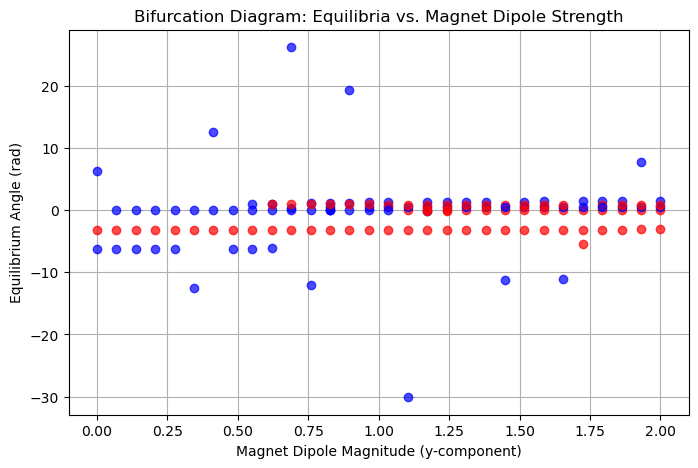

In [83]:
def do_bifurcation_analysis():
    """
    We vary the y-component of the magnet's dipole moment from 0 to 2.0,
    find equilibrium angles, and do a naive stability classification.
    """
    magnet_strengths = np.linspace(0, 2.0, 30)
    eq_angles_by_strength = []
    stability_by_strength = []

    for strength in magnet_strengths:
        pendulum = system(ic=[0.0, 0.0], damp=0.2, moment=1, dt=0.01, t_max=10)
        
        my_magnet = magnet(pos=[1, 1], mom=[0.0, strength])
        pendulum.add_magnet(my_magnet)
        
        eqs = pendulum.find_equil_points(num_points=50)
        
        eq_thetas = []
        eq_stabs  = []
        for eq_point in eqs:
            eq_thetas.append(eq_point[0])  # eq_point is [theta_eq, 0]
            second_deriv = pendulum.check_stability(eq_point)
            eq_stabs.append(second_deriv)
        
        eq_angles_by_strength.append(eq_thetas)
        stability_by_strength.append(eq_stabs)

    return magnet_strengths, eq_angles_by_strength, stability_by_strength


def plot_bifurcation(magnet_strengths, eq_angles_by_strength, stability_by_strength):
    plt.figure(figsize=(8,5))
    for i, mag_str in enumerate(magnet_strengths):
        eqs = eq_angles_by_strength[i]
        stabs = stability_by_strength[i]
        for theta_eq, stab_val in zip(eqs, stabs):
            color = 'blue' if stab_val < 0 else 'red'
            plt.plot(mag_str, theta_eq, marker='o', color=color, alpha=0.7)

    plt.title("Bifurcation Diagram: Equilibria vs. Magnet Dipole Strength")
    plt.xlabel("Magnet Dipole Magnitude (y-component)")
    plt.ylabel("Equilibrium Angle (rad)")
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    magnet_strengths, eq_angles, eq_stabilities = do_bifurcation_analysis()
    
    plot_bifurcation(magnet_strengths, eq_angles, eq_stabilities)


/var/folders/sm/x7qs36992cv1nfylc36tt9rm0000gn/T/ipykernel_89143/1280976223.py:106: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  equillibrium = fsolve(self.rhs, [angle, 0.0], args=(self.magnets, 0))


Equilibrium angles found: [[-3.13894635e+00  0.00000000e+00]
 [-3.77517514e+01  0.00000000e+00]
 [ 4.44089210e-16 -4.45480999e-11]]


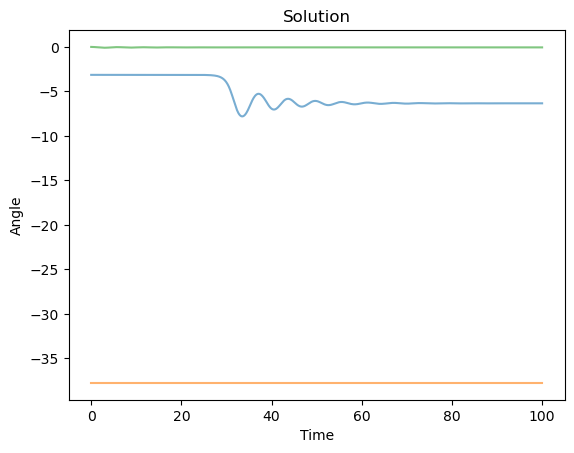

  0   1   2   3   4   5   6   7   8   9
 10  11  12  13  14  15  16  17  18  19
 20  21  22  23  24  25  26  27  28  29
 30  31  32  33  34  35  36  37  38  39
 40  41  42  43  44  45  46  47  48  49
 50  51  52  53  54  55  56  57  58  59
 60  61  62  63  64  65  66  67  68  69
 70  71  72  73  74  75  76  77  78  79
 80  81  82  83  84  85  86  87  88  89
 90  91  92  93  94  95  96  97  98  99
100 101 102 103 104 105 106 107 108 109
110 111 112 113 114 115 116 117 118 119


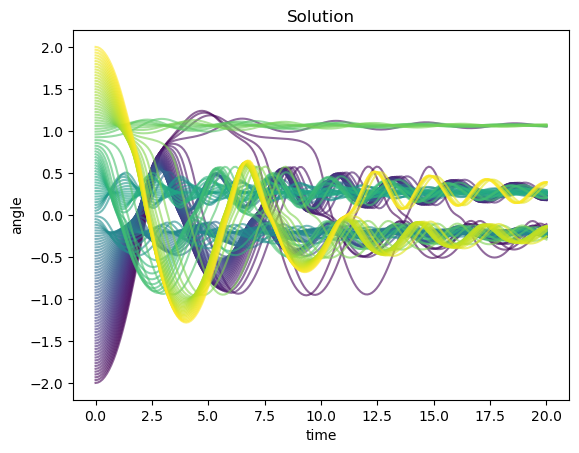

  0   1   2   3   4   5   6   7   8   9
 10  11  12  13  14  15  16  17  18  19
 20  21  22  23  24  25  26  27  28  29
 30  31  32  33  34  35  36  37  38  39
 40  41  42  43  44  45  46  47  48  49


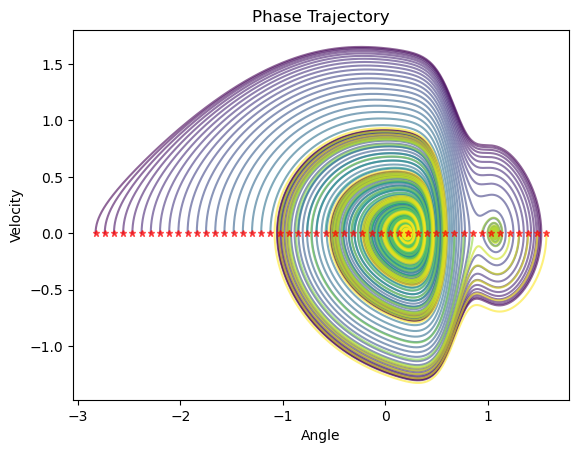

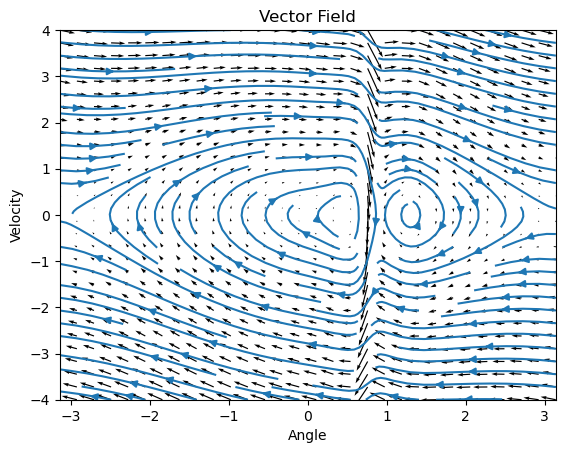

Marcus eq points: [[-3.12885004e+00  0.00000000e+00]
 [ 5.14338239e-01  8.35238972e-53]
 [ 1.26898463e+00 -3.34095589e-52]
 [ 3.01857006e-02  2.12373223e-17]
 [ 4.44089210e-16  4.45480999e-11]
 [ 9.30907822e-01  0.00000000e+00]]


/var/folders/sm/x7qs36992cv1nfylc36tt9rm0000gn/T/ipykernel_89143/1280976223.py:106: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  equillibrium = fsolve(self.rhs, [angle, 0.0], args=(self.magnets, 0))


In [84]:
fig, ax = plt.subplots()

pendulum = system([0, 0])
pendulum.add_magnet(magnet([1, 2], [0, 1]))
pendulum.find_equil_points()
crit_points = pendulum.equil_points
print("Equilibrium angles found:", crit_points)
for crit_point in crit_points:
    pendulum.angle = crit_point[0]  # eq is [theta_eq, 0]
    pendulum.vel = 0
    pendulum.solve()
    pendulum.plot_solution(ax=ax)
    
plt.show()

fig, ax = plt.subplots()

num_sims = 120
colors = plt.cm.viridis(np.linspace(0, 1, num_sims))

for i, phi in enumerate(np.linspace(-2, 2, num_sims)):
    pendulum = system(ic=[phi, 0], t_max=20)
    pendulum.add_magnet(magnet(pos=np.array([1, 1.2]), mom=np.array([0, 1.0])))
    pendulum.add_magnet(magnet(pos=np.array([0, 1.2]), mom=np.array([0, -0.1])))
    pendulum.solve()
    pendulum.plot_solution(ax, colors[i])
    
    print(f"  {i}" if i < 10 else f" {i}" if i < 100 else i, end=" " if (i+1) % 10 else "\n")

ax.set_xlabel("time")
ax.set_ylabel("angle")
plt.show()

fig, ax = plt.subplots()

num_sims = 50
colors = plt.cm.viridis(np.linspace(0, 1, num_sims))

ics = []
for i, phi in enumerate(np.linspace(-0.9 * np.pi, 0.5 * np.pi, num_sims)):
    ics.append([phi, 0])
    pend = system(ic=ics[-1], dt=0.01, t_max=50)
    pend.add_magnet(magnet(pos=np.array([1, 1.2]), mom=np.array([0, 1.0])))
    pend.solve()
    pend.plot_phase(ax, colors[i])
    
    print(f"  {i}" if i < 10 else f" {i}" if i < 100 else i, end=" " if (i+1) % 10 else "\n")

for ic in ics:
    ax.plot(ic[0], ic[1], 'r*', markersize=5, alpha=0.6)

plt.show()

marcus = system(ic=[np.pi / 4, 0], dt=0.1, t_max=30)
marcus.add_magnet(magnet(pos=np.array([1, 1]), mom=np.array([0.0, 1.0])))
marcus.plot_vectorfield(num_angles=30, num_velolcities=30)
plt.show()
marcus.find_equil_points()
print("Marcus eq points:", marcus.equil_points)


In [89]:
def do_bifurcation_with_two_magnets():
    magnet_strengths = np.linspace(0, 2.0, 30)

    eq_angles_by_strength = []
    stability_by_strength = []

    for strength in magnet_strengths:
        pendulum = system(ic=[0.0, 0.0], damp=0.2, dt=0.01, t_max=10.0)

        magA = magnet(pos=[1.0, 1.0], mom=[0.0, strength])
        pendulum.add_magnet(magA)

        magB = magnet(pos=[-5.0, -8.0], mom=[0.0, 1.0])
        pendulum.add_magnet(magB)

        magC = magnet(pos=[-2.0, 1.0], mom=[0.0, 1.0])
        pendulum.add_magnet(magB)

        eqs = pendulum.find_equil_points(num_points=50)


        eq_thetas = []
        eq_stabs  = []
        for eq_point in eqs:
            eq_thetas.append(eq_point[0]) 
            second_deriv = pendulum.check_stability(eq_point)
            eq_stabs.append(second_deriv)

        eq_angles_by_strength.append(eq_thetas)
        stability_by_strength.append(eq_stabs)

    return magnet_strengths, eq_angles_by_strength, stability_by_strength


/var/folders/sm/x7qs36992cv1nfylc36tt9rm0000gn/T/ipykernel_89143/1280976223.py:106: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  equillibrium = fsolve(self.rhs, [angle, 0.0], args=(self.magnets, 0))
/var/folders/sm/x7qs36992cv1nfylc36tt9rm0000gn/T/ipykernel_89143/1280976223.py:106: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  equillibrium = fsolve(self.rhs, [angle, 0.0], args=(self.magnets, 0))


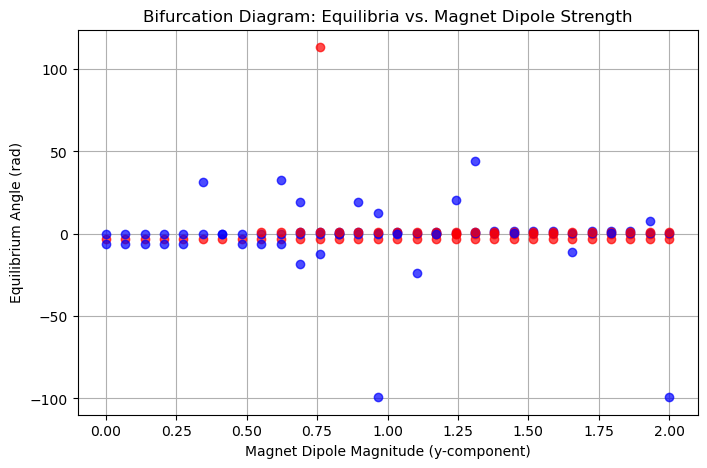

In [90]:
strengths, eq_angles, stabilities = do_bifurcation_with_two_magnets()
plot_bifurcation(strengths, eq_angles, stabilities)
